# Project 3 - Black-Box Policy Optimization

### Import the environment from the course website


In [2]:
!wget  -q https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw3/project3.zip
!unzip -q project3.zip

replace frogger_env/agent/frogger_agent.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame
!pip3 install box2d-py


"""ENVIRONMENT"""
import gym                                                                      #OpenAI gym 
import frogger_env
gym.logger.set_level(40)                                                        #suppresses warning messages, displays only error messages

"""MODELS AND TOOLS FOR OPTIMIZATION AND OTHER COMPUTATIONS"""
import time
import numpy as np
import torch                                                                    #will use PyTorch to handle the NN 
import torch.nn as nn                                                           #contains various NN layers
import torch.nn.functional as F                                                 #includes various functions such as convolution etc.
import torch.optim as optim                                                     #contains various optimization algorithms
import random
from random import sample
from collections import deque

"""VISUALIZATION"""
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

"""I/O"""
import os
from pathlib import Path

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

### Display for visualization

In [4]:
display=Display(visible=0, size=(600, 400))
display.start()

#Define a simple helper function to visualize the episodes
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

###Testing things out!

In [5]:
env = gym.make("CartPole-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = 1
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

The observation that the agent receives is its position, the goal position, and a unit vector that points from the agent's position to the goal.

The action space consists of four actions 0: move up, 1: move down, 2: move right 3: move left

In [6]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: 2


###Some useful functions

In [5]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your policy network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)

###Cross Entropy Method
Implement below the cross-entropy method to solve the reacher-v0 environment and enable the agent to learn to navigate to a fixed goal position on a static highway map. Please, refer to the project descriprtion and lecture 13 for more details.

In [ ]:
from scipy.stats import norm
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE NEURAL NETWORK"""
class network(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3):
    super(network, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is a fully-connected layer with #I/P=observations and #hidden units=hu1
    self.l2=nn.Linear(hu1,actions)                                              #layer2 is a fully-connected layer with #I/P=hu1 and #hidden units=actions
    #self.l3=nn.Linear(hu2,actions)
    #initialize interconnection weights and bias weights using a probability
    #distribution (code below is for a normal distribution with μ=0 and σ=1)
    #nn.init.normal_(self.l1.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l1.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l2.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l2.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l3.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l3.bias.data,mean=0,std=1)

  def forward(self, x):                                                         #forward propagation function
    if not isinstance(x,torch.Tensor):                                          #check if the I/P is a tensor or not
      x=torch.tensor(x,device=device,dtype=torch.float32)                       #convert the I/P to a tensor and move it to 'device'
      x=x.unsqueeze(0)
    x=F.relu(self.l1(x))
    #x=F.relu(self.l2(x))
    x=F.tanh(self.l2(x))
    return x



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE CEM AGENT"""
class CEMagent():
  def __init__(self,observations,actions,hu1,hu2,hu3):
    self.policynet=network(observations,actions,hu1,hu2,hu3).to(device)         #define a policy-network object of type 'network', initialize its weights θ randomly and move it to the GPU
    self.tempnet=network(observations,actions,hu1,hu2,hu3).to(device)           #define a dummy netowrk object of type 'network', initialize its weights θ randomly and move it to the GPU

  def train(self, env,seed,gamma,mean,sigma,n,k,maxIterations):
    self.gamma=gamma
    self.mean=mean
    self.sigma=sigma
    self.dimension=sum(p.numel() for p in self.policynet.parameters())
    torch.manual_seed(seed) 
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    self.evalScoreIteration=[]                                                  #stores evaluation score at the end of each weigth update
    iterations=0
    while iterations<maxIterations:
      iterations+=1      
      theta_is=[]                                                               #stores all perturbations of θ
      for i in range(n):                                                        #run this loop 'n' times to collect 'n' perturbations of θ
        theta_is.append(self.perturbations())
      G_is=self.rollOut(env,theta_is)                                           #call this function to perform a roll-out corresponding to each θ, and calculate the corresponding reward R(τi)
      indices=np.argsort(G_is)[-k:].tolist()                                    #extract indices of the highest k% of Gi where Gi=R(τi)
      theta_is=[theta_is[index] for index in indices]                           #use the extracted indices to identify the corresponding θi
      self.weightUpdate(theta_is)                                               #update the weights of the policy network using the identifed θi 
      evalScore=self.evaluate(env)                                              #perform a roll-out after each round of weight update            
      self.evalScoreIteration.append(evalScore)      
      print('Iteration#: {:d}\tEvaluation reward: {:.2f}\tMean evaluation reward: {:.2f}\tSTD of evaluation reward: {:.2f}'.format(iterations,evalScore,np.mean(self.evalScoreIteration),np.std(self.evalScoreIteration)))
      if np.mean(self.evalScoreIteration)>=160.0 and iterations!=1:
        break
    return self.evalScoreIteration

  def perturbations(self):
    temp=torch.cat([parameter.view(-1) for parameter in self.policynet.parameters()])
    perturbation=temp+(self.mean+(self.sigma*torch.randn(self.dimension).to(device)))
    return perturbation

  def rollOut(self,env,theta_is):
    R=[]                                                                        #list stores R(τi) of each τi
    for i in theta_is:
      temp=self.tempnet.state_dict()
      theta_i=torch.tensor(i).to(device)
      lLimit,hLimit=0,0
      for label,parameter in zip(temp,self.tempnet.parameters()):               #iterate over each label of 'temp' and each parameter of the policy network
        hLimit=lLimit+sum(p.numel() for p in temp[label])
        temp[label]=torch.reshape(theta_i[lLimit:hLimit],temp[label].size())    #generate a perturbation of the current parameter using the expression θ=θ+σε
        lLimit=hLimit
      self.tempnet.load_state_dict(temp)
      terminal=False
      numExperiences=0
      s=env.reset()
      R.append(0.0)
      while not terminal:
        s=torch.tensor(s).type(torch.FloatTensor).to(device)
        with torch.no_grad():
          Q=self.tempnet(s).cpu().detach().data.numpy().squeeze()
        action=np.argmax(Q)
        sP,r,terminal,info=env.step(action)
        s=sP
        numExperiences+=1
        R[-1]+=(self.gamma**(numExperiences-1))*r                               #sum of discounted rewards of the current trajectory
    return R

  def weightUpdate(self,theta_is):                                              #this function updates the weights of the policy network
    temp=self.policynet.state_dict()                                            #create a copy of the weights of the policy network
    for label,parameter in zip(temp,self.policynet.parameters()):               #iterate over each label of 'temp' and each parameter of the policy network
      temp[label]=torch.zeros_like(parameter)                                   #initialize all weights to zeros
    for i in theta_is:                                                          #loop over each selected θi
      theta_i=torch.tensor(i).to(device)                                        #convert selected θi to tensor
      lLimit,hLimit=0,0
      for label in temp:                                                        #loop over each label of 'temp'
        hLimit=lLimit+sum(parameter.numel() for parameter in temp[label])
        temp[label]+=torch.reshape(theta_i[lLimit:hLimit],temp[label].size())   #add current component of current θi to the corresponding component of 'temp'
        lLimit=hLimit
    for label in temp:                                                          #loop over all labels of 'temp' and calculate the average of each element in its components
      temp[label]/=len(theta_is)
    self.policynet.load_state_dict(temp)

  def evaluate(self,env,rollOuts=1):                                            #this function performs a fixed #roll-outs at the end of each training episode and evaluates the associated rewards
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s1=env.reset()
      terminal1=False
      numExperiences=0
      while not terminal1:
        s1=torch.tensor(s1).float().to(device)
        a1=self.greedy(s1)
        s1,r1,terminal1,info1=env.step(a1)
        numExperiences+=1
        rewards[-1]+=(self.gamma**(numExperiences-1))*r1
    return np.mean(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to the Q-values of the state 's'
    with torch.no_grad():
      Q=self.policynet(s)
    Q=Q.cpu().numpy()
    return np.argmax(Q)



"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('CartPole-v0')                                                      #declare the environment variable
hu1=16                                                                          #size of the first hidden layer of the NN
hu2=10                                                                          #size of the second hidden layer of the NN
hu3=5
gamma=1                                                                       #the discount factor
maxIterations=2000                                                              #maximum iterations for which is θ updated
seed=6                                                                          #random seed used for random initialization of the network weights, the environment and various random function
sigma=.1                                                                        #standard deviation for perturbing θ
mean=.01                                                                        #mean for perturbing θ
n=100                                                                           ##perturbations of θ
k=20                                                                            #select the best k% θi from θ
meanReward100=env.spec.reward_threshold                                         #mean reward earned over the last 100 episodes
observations=env.observation_space.shape[0]                                     ##observations or I/P features
actions=env.action_space.n                                                      #actions




"""CEM"""
env.seed(seed)                                                                  #set the seed for the environment
agent=CEMagent(observations,actions,hu1,hu2,hu3)                                #create an object of type 'CEMagent'
result=agent.train(env,seed,gamma,mean,sigma,n,k,maxIterations)                 #train the CEM agent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration#: 1	Evaluation reward: 47.00	Mean evaluation reward: 47.00	STD of evaluation reward: 0.00
Iteration#: 2	Evaluation reward: 132.00	Mean evaluation reward: 89.50	STD of evaluation reward: 42.50
Iteration#: 3	Evaluation reward: 55.00	Mean evaluation reward: 78.00	STD of evaluation reward: 38.32
Iteration#: 4	Evaluation reward: 70.00	Mean evaluation reward: 76.00	STD of evaluation reward: 33.37
Iteration#: 5	Evaluation reward: 126.00	Mean evaluation reward: 86.00	STD of evaluation reward: 35.93
Iteration#: 6	Evaluation reward: 137.00	Mean evaluation reward: 94.50	STD of evaluation reward: 37.91
Iteration#: 7	Evaluation reward: 172.00	Mean evaluation reward: 105.57	STD of evaluation reward: 44.35
Iteration#: 8	Evaluation reward: 110.00	Mean evaluation reward: 106.12	STD of evaluation reward: 41.51
Iteration#: 9	Evaluation reward: 200.00	Mean evaluation reward: 116.56	STD of evaluation reward: 49.01
Iteration#: 10	Evaluation reward: 200.00	Mean evaluation reward: 124.90	STD of eval

###Test the policy

In [ ]:
"""TESTING"""
env=gym.make('CartPole-v0')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
#env.seed(10)
s=env.reset()
terminal=False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent.greedy(s)
  s,r,terminal,info=env.step(a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')

###Q1. Cross Entropy Method with Adaptive Exploration
Implement below the cross-entropy method to solve the reacher-v0 environment and enable the agent to learn to navigate to a fixed goal position on a static highway map. Please, refer to the project descriprtion and lecture 13 for more details.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration#: 1	Step#: 4897	Evaluation reward: -0.30	Mean evaluation reward: -0.30	STD of evaluation reward: 0.00
Iteration#: 2	Step#: 10873	Evaluation reward: -0.30	Mean evaluation reward: -0.30	STD of evaluation reward: 0.00
Iteration#: 3	Step#: 14996	Evaluation reward: -0.30	Mean evaluation reward: -0.30	STD of evaluation reward: 0.00
Iteration#: 4	Step#: 18801	Evaluation reward: 0.04	Mean evaluation reward: -0.22	STD of evaluation reward: 0.14
Iteration#: 5	Step#: 25828	Evaluation reward: 0.04	Mean evaluation reward: -0.16	STD of evaluation reward: 0.16
Iteration#: 6	Step#: 33003	Evaluation reward: -0.31	Mean evaluation reward: -0.19	STD of evaluation reward: 0.16
Iteration#: 7	Step#: 41429	Evaluation reward: 0.05	Mean evaluation reward: -0.15	STD of evaluation reward: 0.17
Iteration#: 8	Step#: 50841	Evaluation reward: -0.31	Mean evaluation reward: -0.17	STD of evaluation reward: 0.17
Iteration#: 9	Step#: 61510	Evaluation reward: 1.41	Mean evaluation reward: 0.00	STD of evaluation re

Text(0.5, 1.0, '#time-steps v/s #iterations')

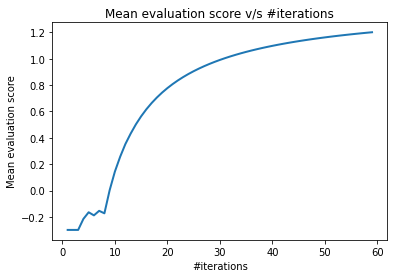

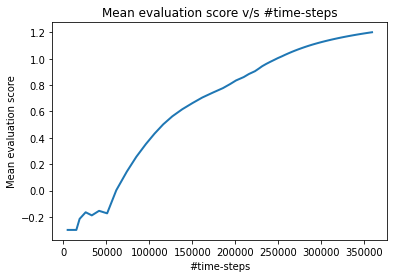

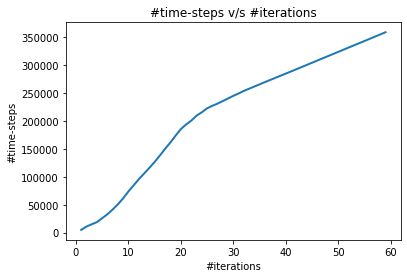

In [22]:
from scipy.stats import norm
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE NEURAL NETWORK"""
class network(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3):
    super(network, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is a fully-connected layer with #I/P=observations and #hidden units=hu1
    self.l2=nn.Linear(hu1,actions)                                              #layer2 is a fully-connected layer with #I/P=hu1 and #output units=actions
    #initialize interconnection weights and bias weights using a probability
    #distribution (code below is for a normal distribution with μ=0 and σ=1)
    #nn.init.normal_(self.l1.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l1.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l2.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l2.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l3.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l3.bias.data,mean=0,std=1)

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          #check if the I/P is a tensor or not
      x=torch.tensor(x,device=device,dtype=torch.float32)                       #convert the I/P to a tensor and move it to 'device'
      x=x.unsqueeze(0)
    x=F.relu(self.l1(x))
    x=self.l2(x)
    return x



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE CEM AGENT"""
class CEMagent():
  def __init__(self,observations,actions,hu1,hu2,hu3):
    self.policynet=network(observations,actions,hu1,hu2,hu3).to(device)         #define a policy-network object of type 'network', initialize its weights θ randomly and move it to the GPU
    self.tempnet=network(observations,actions,hu1,hu2,hu3).to(device)           #define a dummy netowrk object of type 'network', initialize its weights θ randomly and move it to the GPU

  def train(self,env,seed,mean,sigma,gamma,n,k,maxIterations):
    self.gamma=gamma
    self.steps=0                                                                #stores the total #time-steps (or experiences) collected during the training process
    self.dimension=sum(p.numel() for p in self.policynet.parameters())          #total #interconnection weights of the NN
    self.mean=mean*torch.ones(self.dimension)                                   #initial mean is a vector of dimension 'self.dimension with all elements being equal to 'mean'
    self.sigma=sigma*torch.ones(self.dimension)                                 #initial std is a vector of dimension 'self.dimension with all elements being equal to 'sigma'
    torch.manual_seed(seed) 
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    self.evalScoreIteration=[]                                                  #stores the evaluation score of each roll-out
    self.results=[]                                                             #stores the results tuple
    iterations=0
    while iterations<maxIterations:
      iterations+=1
      theta_is=[]                                                               #stores all perturbations θi
      for i in range(n):                                                        #run this loop 'n' times to collect 'n' perturbations of θ
        theta_is.append(self.perturbations())
      G_is=self.rollOut(env,theta_is)                                           #call this function to perform a roll-out corresponding to each θ, and calculate the corresponding reward Gi=R(τi)
      indices=np.argsort(G_is)[-k:].tolist()                                    #extract indices of the highest k% of Gi where Gi=R(τi)
      theta_is=[theta_is[index] for index in indices]                           #use the extracted indices to identify the corresponding θi
      self.weightUpdate(theta_is,k)                                             #update the weights of the policy network
      self.fit(theta_is)                                                        #call this function to fit a new distribution to the selected best θi
      evalScore=self.evaluate(env)                                              #perform a roll-out after each round of weight update            
      self.evalScoreIteration.append(evalScore)      
      print('Iteration#: {:d}\tStep#: {:d}\tEvaluation reward: {:.2f}\tMean evaluation reward: {:.2f}\tSTD of evaluation reward: {:.2f}'.format(iterations,self.steps,evalScore,np.mean(self.evalScoreIteration),np.std(self.evalScoreIteration)))
      self.results.append((iterations,self.steps,evalScore,np.mean(self.evalScoreIteration),np.std(self.evalScoreIteration)))
      if np.mean(self.evalScoreIteration)>=1.2 and iterations!=1:               #break the algorithm if the mean reward over all roll-outs exceeds 1.2
        break
    return self.results,self.policynet

  def perturbations(self):                                                      #this function generates perturbations θi
    perturbation=self.mean+(self.sigma*torch.randn(self.dimension))
    return perturbation

  def rollOut(self,env,theta_is):                                               #this function executes one roll-out for each θi and collects the corresponding reward R(τi)
    R=[]                                                                        #list stores R(τi) of each τi
    temp=self.tempnet.state_dict()
    for i in theta_is:
      theta_i=torch.tensor(i).to(device)                                        #as θi is not a tensor, make it one and move it to the GPU
      lLimit,hLimit=0,0                                                         #these two variables form the upper and lower limit of weight slices
      for label,parameter in zip(temp,self.tempnet.parameters()):               #iterate over each label of 'temp' and each parameter of the policy network
        hLimit=lLimit+sum(p.numel() for p in temp[label])
        temp[label]=torch.reshape(theta_i[lLimit:hLimit],temp[label].size())    #generate a perturbation of the current parameter using the expression θ=θ+σε
        lLimit=hLimit
      self.tempnet.load_state_dict(temp)                                        #use θi as the weight of 'tempnet' and use the latter to execute a roll-out
      terminal=False
      numExperiences=0
      s=env.reset()
      R.append(0.0)
      while not terminal:                                                       #run the episode until it terminates
        self.steps+=1                                                           #each step in the episode is considered as one time-step (or experience)
        s=torch.tensor(s).type(torch.FloatTensor).to(device)
        with torch.no_grad():
          Q=self.tempnet(s).cpu().detach().data.numpy().squeeze()
        action=np.argmax(Q)
        sP,r,terminal,info=env.step(action)
        s=sP
        numExperiences+=1
        R[-1]+=(self.gamma**(numExperiences-1))*r                               #sum of discounted rewards of the current trajectory (or episode)
    return R

  def weightUpdate(self,theta_is,k):                                            #this function updates the weights of the policy network
    temp=self.policynet.state_dict()                                            #create a copy of the weights of the policy network
    for label,parameter in zip(temp,self.policynet.parameters()):               #iterate over each label of 'temp' and each parameter of the policy network
      temp[label]=torch.zeros_like(parameter)                                   #initialize all weights to zeros
    for i in theta_is:                                                          #loop over each selected θi
      theta_i=torch.tensor(i).to(device)                                        #convert selected θi to tensor and move it to the GPU
      lLimit,hLimit=0,0                                                         #these two variables form the upper and lower limit of weight slices
      for label in temp:                                                        #loop over each label of 'temp'
        hLimit=lLimit+sum(parameter.numel() for parameter in temp[label])
        temp[label]+=torch.reshape(theta_i[lLimit:hLimit],temp[label].size())   #add current component of current θi to the corresponding component of 'temp'
        lLimit=hLimit
    for label in temp:                                                          #loop over all labels of 'temp' and calculate the average of each element in its components
      temp[label]/=k
    self.policynet.load_state_dict(temp)                                        #replace the weights of the policy network θ with the new weight θnew

  def fit(self,theta_is):                                                       #this function fits a distribution to the selected best θi
    temp=torch.stack(theta_is)
    self.mean=torch.mean(temp,0)
    self.sigma=torch.std(temp,0)

  def evaluate(self,env,rollOuts=1):                                            #this function performs a fixed #roll-outs at the end of each training episode and evaluates the associated rewards
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s1=env.reset()
      terminal1=False
      numExperiences=0
      while not terminal1:                                                      #run the episode until it terminates
        s1=torch.tensor(s1).float().to(device)
        a1=self.greedy(s1)
        s1,r1,terminal1,info1=env.step(a1)
        numExperiences+=1
        rewards[-1]+=(self.gamma**(numExperiences-1))*r1
    return np.mean(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to the Q-values of the state 's'
    with torch.no_grad():
      Q=self.policynet(s)
    Q=Q.cpu().numpy()
    return np.argmax(Q)


"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('reacher-v0')                                                      #declare the environment variable
hu1=17                                                                          #size of the first hidden layer of the NN
hu2=15                                                                          #size of the second hidden layer (if any) of the NN
hu3=5                                                                           #size of the third hidden layer (if any) of the NN
gamma=.999                                                                      #the discount factor
maxIterations=2000                                                              #maximum iterations
seed=8                                                                          #random seed used for random initialization of the network weights, the environment and various random function
sigma=.5                                                                        #initial standard deviation for perturbing θ
mean=.01                                                                        #initial mean for perturbing θ
n=300                                                                           ##perturbations of θ
k=5                                                                             #select the best k% θi from θ
meanReward100=env.spec.reward_threshold                                         #mean reward earned over the last 100 episodes
observations=env.observation_space.shape[0]                                     ##observations or I/P features
actions=env.action_space.n                                                      #actions



"""CEM"""
env.seed(seed)                                                                  #set the seed for the environment
agent=CEMagent(observations,actions,hu1,hu2,hu3)                                #create an object of type 'CEMagent'
results,model=agent.train(env,seed,mean,sigma,gamma,n,k,maxIterations)          #train the CEM agent
save_checkpoint(model,'model1',1)                                               #save the model in Google Drive



"""PLOT THE RESULTS"""
trainResults=np.array(results)
numIterations=trainResults[:,0]                                                 #total #iterations
numSteps=trainResults[:,1]                                                      #total #time-steps
meanEvalScore=trainResults[:,3]                                                 #mean evaluation score

figure1=plt.figure()                                                            #plot the #iterations
axis1=figure1.add_subplot(111)
plt.plot(numIterations,meanEvalScore,linewidth=2)
plt.ylabel('Mean evaluation score')
plt.xlabel('#iterations')
axis1.set_title('Mean evaluation score v/s #iterations')

figure2=plt.figure()                                                            #plot the #time-steps
axis2=figure2.add_subplot(111)
plt.plot(numSteps,meanEvalScore,linewidth=2)
plt.ylabel('Mean evaluation score')
plt.xlabel('#time-steps')
axis2.set_title('Mean evaluation score v/s #time-steps')

figure3=plt.figure()                                                            #plot the #time-steps versus #episodes
axis3=figure3.add_subplot(111)
plt.plot(numIterations,numSteps,linewidth=2)
plt.xlabel('#iterations')
plt.ylabel('#time-steps')
axis3.set_title('#time-steps v/s #iterations')

###Test the policy

In [73]:
"""TESTING"""
env=gym.make('reacher-v0')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
#env.seed(10)
s=env.reset()
terminal=False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent.greedy(s)
  s,r,terminal,info=env.step(a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>

Episode reward:1.4336206947403212


###Q2. Evolution Strategy Salimas et al. 2017
Implement below the non-distributed version of the evolution strategies method from  [[Salimans et al., 2017]](https://arxiv.org/pdf/1703.03864.pdf) to solve the LunarLanderContinuous-v2 environment and enable the agent to navigate to its landing pad. Please, refer to the project descriprtion and lecture 13 for more details.

First, let's test the new environment out!

In [ ]:
display=Display(visible=0,size=(900,400))
display.start()

env=gym.make("LunarLanderContinuous-v2")
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
env.reset()
done=False
while not done:
  action=env.action_space.sample()
  obs,reward,done,info=env.step(action)
env.close()
show_video('./video')

The observation that the agent receives is its position, velocity, angular speed, and two 2 Boolean flags indicating whether the left and right leg of the agent, respectively, is in contact with the ground.

Two continuous actions are used to control the agent. The first one controls the main engine and the second one controls the left and right engines. *The expected range of each of the two actions is [-1, 1]. Please make sure that your policy network outputs values in that range*

In [ ]:
print('observation space:',env.observation_space)
print('action space:',env.action_space)
print('solved_score',env.spec.reward_threshold)

### Implement a policy network that the agent can use to select actions. 
Instead of training the parameters of the network, you will directly set them based on your ES optimization.

In [ ]:
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE NEURAL NETWORK"""
class network2(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3=2):
    super(network2, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is a fully-connected layer with #I/P=observations and #hidden units=hu1
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is a fully-connected layer with #I/P=hu1 and #hidden units=hu2
    self.l3=nn.Linear(hu2,actions)                                              #layer3 is a fully-connected layer with #I/P=hu2 and #units=actions

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          #check if the I/P is a tensor or not
      x=torch.tensor(x,device=device,dtype=torch.float32)                       #convert the I/P to a tensor and move it to 'device'
      x=x.unsqueeze(0)
    x=torch.tanh(self.l1(x))
    x=torch.tanh(self.l2(x))
    x=torch.tanh(self.l3(x))
    return x



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE CEM AGENT"""
class ESagent():
  def __init__(self,observations,actions,hu1,hu2):
    self.policynet=network2(observations,actions,hu1,hu2).to(device)            #define a policy-network object of type 'network2', initialize its weights θ randomly and move it to the GPU
    self.tempnet=network2(observations,actions,hu1,hu2).to(device)              #define a dummy netowrk object of type 'network2', initialize its weights θ randomly and move it to the GPU

  def train(self,env,seed,alpha,momentum,sigma,gamma,n,maxIterations):
    self.alpha=alpha
    self.momentum=momentum
    self.gamma=gamma
    self.sigma=sigma
    self.steps=0
    self.dimension=sum(p.numel() for p in self.policynet.parameters())
    torch.manual_seed(seed) 
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    self.evalScoreIteration=[]
    self.results=[]
    iterations=0
    while iterations<maxIterations:
      iterations+=1
      theta_is=[]
      noise_is=[]
      for i in range(n):                                                        #run this loop 'n' times to collect 'n' perturbations of θ
        theta_i,noise_i=self.perturbations()
        theta_is.append(theta_i)
        noise_is.append(noise_i)
      G_is=self.rollOut(env,theta_is)                                           #call this function to perform a roll-out corresponding to each θ, and calculate the corresponding reward R(τi)
      self.weightUpdate(G_is,noise_is,n)                                        #update the weights of the policy network using the ide
      evalScore=self.evaluate(env)                                              #perform a roll-out after each round of weight update            
      self.evalScoreIteration.append(evalScore)      
      print('Iteration#: {:d}\tStep#: {:d}\tEvaluation reward: {:.2f}\t\u03BC evaluation reward: {:.2f}\t\u03C3 of evaluation reward: {:.2f}\t\u03BC\u2085\u2080 evaluation reward: {:.2f}'.format(iterations,self.steps,evalScore,np.mean(self.evalScoreIteration),np.std(self.evalScoreIteration),np.mean(self.evalScoreIteration[-50:])))
      self.results.append((iterations,self.steps,evalScore,np.mean(self.evalScoreIteration),np.std(self.evalScoreIteration),np.mean(self.evalScoreIteration[-50:])))
      if np.mean(self.evalScoreIteration[-50:])>=100.0 and iterations!=1:
        break
    return self.results,self.policynet

  def perturbations(self):
    temp=torch.cat([parameter.view(-1) for parameter in self.policynet.parameters()])
    noise=self.sigma*torch.randn(self.dimension).to(device)
    perturbation=temp+noise
    return perturbation,noise

  def rollOut(self,env,theta_is):
    R=[]                                                                        #list stores R(τi) of each τi
    temp=self.tempnet.state_dict()
    for i in theta_is:
      theta_i=torch.tensor(i).to(device)
      lLimit,hLimit=0,0
      for label,parameter in zip(temp,self.tempnet.parameters()):               #iterate over each label of 'temp' and each parameter of the policy network
        hLimit=lLimit+sum(p.numel() for p in temp[label])
        temp[label]=torch.reshape(theta_i[lLimit:hLimit],temp[label].size())    #generate a perturbation of the current parameter using the expression θ=θ+σε
        lLimit=hLimit
      self.tempnet.load_state_dict(temp)
      terminal=False
      numExperiences=0
      s=env.reset()
      R.append(0.0)
      while not terminal:
        self.steps+=1
        s=torch.tensor(s).type(torch.FloatTensor).to(device)
        with torch.no_grad():
          Q=self.tempnet(s).cpu().detach().data.numpy().squeeze()
        action=Q
        sP,r,terminal,info=env.step(action)
        s=sP
        numExperiences+=1
        R[-1]+=(self.gamma**(numExperiences-1))*r                               #sum of discounted rewards of the current trajectory
    return R

  def weightUpdate(self,G_is,noise_is,n):                                       #this function updates the weights of the policy network
    temp=self.policynet.state_dict()                                            #create a copy of the weights of the policy network
    update=torch.zeros(self.dimension).to(device)
    G_is=np.array(G_is)
    G_is=((G_is-np.mean(G_is))/np.std(G_is)).tolist()
    for i in range(n):
      update+=G_is[i]*noise_is[i]
    update*=((self.momentum*self.alpha)/(n*self.sigma))
    lLimit,hLimit=0,0
    for label in temp:
      hLimit=lLimit+sum(p.numel() for p in temp[label])
      temp[label]+=torch.reshape(update[lLimit:hLimit],temp[label].size())
      lLimit=hLimit
    self.policynet.load_state_dict(temp)

  def evaluate(self,env,rollOuts=1):                                            #this function performs a fixed #roll-outs at the end of each training episode and evaluates the associated rewards
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s1=env.reset()
      terminal1=False
      numExperiences=0
      while not terminal1:
        s1=torch.tensor(s1).float().to(device)
        a1=self.greedy(s1)
        s1,r1,terminal1,info1=env.step(a1)
        numExperiences+=1
        rewards[-1]+=(self.gamma**(numExperiences-1))*r1
    return np.mean(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to the Q-values of the state 's'
    with torch.no_grad():
      Q=self.policynet(s)
    Q=Q.cpu().numpy()
    return Q



"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('LunarLanderContinuous-v2')                                        #declare the environment variable
hu1=30                                                                          #size of the first hidden layer of the NN
hu2=30                                                                          #size of the second hidden layer of the NN
gamma=0.999                                                                     #the discount factor
maxIterations=500                                                              #maximum iterations for which is θ updated
seed=1                                                                          #random seed used for random initialization of the network weights, the environment and various random function
sigma=.1                                                                        #standard deviation for perturbing θ
alpha=0.3                                                                      #the learning rate
momentum=1
n=50                                                                            ##perturbations of θ
observations=env.observation_space.shape[0]                                     ##observations or I/P features
actions=2                                                                       ##continuous actions



"""ES"""
env.seed(seed)                                                                  #set the seed for the environment
agent=ESagent(observations,actions,hu1,hu2)                                     #create an object of type 'ESagent'
results,model=agent.train(env,seed,alpha,momentum,sigma,gamma,n,maxIterations)
save_checkpoint(model,'model2',1)                                               #save the model in Google Drive



"""PLOT THE RESULTS"""
trainResults=np.array(results)
numIterations=trainResults[:,0]                                                 #total #iterations
numSteps=trainResults[:,1]                                                      #total #time-steps
meanEvalScore=trainResults[:,3]                                                 #mean evaluation score of all evaluations
meanEvalScore50=trainResults[:,5]                                               #mean evaluation score for last 50 evaluations

figure1=plt.figure()                                                            #plot mean evaluation score against #iterations
axis1=figure1.add_subplot(111)
plt.plot(numIterations,meanEvalScore,linewidth=2)
plt.ylabel('Mean evaluation score')
plt.xlabel('#iterations')
axis1.set_title('Mean evaluation score v/s #iterations')

figure2=plt.figure()                                                            #plot mean evaluation score against #time-steps
axis2=figure2.add_subplot(111)
plt.plot(numSteps,meanEvalScore,linewidth=2)
plt.ylabel('Mean evaluation score')
plt.xlabel('#time-steps')
axis2.set_title('Mean evaluation score v/s #time-steps')

figure3=plt.figure()                                                            #plot the #time-steps versus #episodes
axis3=figure3.add_subplot(111)
plt.plot(numIterations,numSteps,linewidth=2)
plt.xlabel('#iterations')
plt.ylabel('#time-steps')
axis3.set_title('#time-steps v/s #iterations')

figure4=plt.figure()                                                            #plot mean evaluation score for last 50 evaluations against #iterations
axis4=figure4.add_subplot(111)
plt.plot(numIterations,meanEvalScore50,linewidth=2)
plt.xlabel('#iterations')
plt.ylabel('Mean evaluation score')
axis4.set_title('Mean evaluation score for last 50 evaluations v/s #iterations')

figure5=plt.figure()                                                            #plot mean evaluation score for last 50 evaluations against #time-steps
axis5=figure5.add_subplot(111)
plt.plot(numSteps,meanEvalScore50,linewidth=2)
plt.xlabel('#time-steps')
plt.ylabel('Mean evaluation score')
axis5.set_title('Mean evaluation score for last 50 evaluations v/s #time-steps')

Consolidated results

In [ ]:
env.seed(1)                                                                  #set the seed for the environment
agent=ESagent(observations,actions,hu1,hu2) 
results1,model=agent.train(env,1,alpha,momentum,sigma,gamma,n,maxIterations)
env.seed(6)                                                                  #set the seed for the environment
agent=ESagent(observations,actions,hu1,hu2) 
results6,model=agent.train(env,6,alpha,momentum,sigma,gamma,n,maxIterations)
env.seed(25)                                                                  #set the seed for the environment
agent=ESagent(observations,actions,hu1,hu2) 
results25,model=agent.train(env,25,alpha,momentum,sigma,gamma,n,maxIterations)


"""PLOT THE RESULTS"""
trainResults1=np.array(results1)
numIterations1=trainResults1[:,0]                                                 #total #iterations
numSteps1=trainResults1[:,1]                                                      #total #time-steps
meanEvalScore1=trainResults1[:,3]                                                 #mean evaluation score of all evaluations
trainResults6=np.array(results6)
numIterations6=trainResults6[:,0]                                                 #total #iterations
numSteps6=trainResults6[:,1]                                                      #total #time-steps
meanEvalScore6=trainResults6[:,3]                                                 #mean evaluation score of all evaluations
trainResults25=np.array(results25)
numIterations25=trainResults25[:,0]                                                 #total #iterations
numSteps25=trainResults25[:,1]                                                      #total #time-steps
meanEvalScore25=trainResults25[:,3]                                                 #mean evaluation score of all evaluations


figure1=plt.figure()                                                            #plot mean evaluation score against #iterations
axis1=figure1.add_subplot(111)
plt.hold('True')
plt.plot(numIterations1,meanEvalScore1,'b',label='Seed 1',linewidth=2)
plt.plot(numIterations6,meanEvalScore6,'g',label='Seed 6',linewidth=2)
plt.plot(numIterations25,meanEvalScore25,'r',label='Seed 25',linewidth=2)
plt.legend(loc="upper left")
plt.ylabel('Mean evaluation score')
plt.xlabel('#iterations')
axis1.set_title('Mean evaluation score v/s #iterations')

figure2=plt.figure()                                                            #plot mean evaluation score against #time-steps
axis2=figure2.add_subplot(111)
plt.hold('True')
plt.plot(numSteps1,meanEvalScore1,'b',label='Seed 1',linewidth=2)
plt.plot(numSteps6,meanEvalScore6,'g',label='Seed 6',linewidth=2)
plt.plot(numSteps25,meanEvalScore25,'r',label='Seed 25',linewidth=2)
plt.legend(loc="upper left")
plt.ylabel('Mean evaluation score')
plt.xlabel('#time-steps')
axis2.set_title('Mean evaluation score v/s #time-steps')

figure3=plt.figure()                                                            #plot the #time-steps versus #episodes
axis3=figure3.add_subplot(111)
plt.hold('True')
plt.plot(numIterations1,numSteps1,'b',label='Seed 1',linewidth=2)
plt.plot(numIterations6,numSteps6,'g',label='Seed 6',linewidth=2)
plt.plot(numIterations25,numSteps25,'r',label='Seed 25',linewidth=2)
plt.legend(loc="upper left")
plt.xlabel('#iterations')
plt.ylabel('#time-steps')
axis3.set_title('#time-steps v/s #iterations')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration#: 1	Step#: 4342	Evaluation reward: -131.05	μ evaluation reward: -131.05	σ of evaluation reward: 0.00	μ₅₀ evaluation reward: -131.05
Iteration#: 2	Step#: 8371	Evaluation reward: -120.16	μ evaluation reward: -125.60	σ of evaluation reward: 5.45	μ₅₀ evaluation reward: -125.60
Iteration#: 3	Step#: 12446	Evaluation reward: -102.53	μ evaluation reward: -117.91	σ of evaluation reward: 11.75	μ₅₀ evaluation reward: -117.91
Iteration#: 4	Step#: 15979	Evaluation reward: -107.17	μ evaluation reward: -115.23	σ of evaluation reward: 11.19	μ₅₀ evaluation reward: -115.23
Iteration#: 5	Step#: 19607	Evaluation reward: -117.82	μ evaluation reward: -115.75	σ of evaluation reward: 10.06	μ₅₀ evaluation reward: -115.75
Iteration#: 6	Step#: 23163	Evaluation reward: -159.43	μ evaluation reward: -123.03	σ of evaluation reward: 18.69	μ₅₀ evaluation reward: -123.03
Iteration#: 7	Step#: 26660	Evaluation reward: -124.38	μ evaluation reward: -123.22	σ of evaluation reward: 17.31	μ₅₀ evaluation reward: -123

Test the policy

In [ ]:
display=Display(visible=0,size=(900,400))
display.start()
"""TESTING"""
env=gym.make("LunarLanderContinuous-v2")
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
#env.seed(10)
s=env.reset()
terminal=False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  action=agent.greedy(s)
  #action=env.action_space.sample()
  s,r,terminal,info=env.step(action)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')